# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# import libraries and json datasets

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Objective

In this project, I will make a machine learning model which predicts a probability for offer completion based on demographic data of a customer and data from offer portfolio. We can utilize as a recommendation system for the company about 'which offer will be most effective for a specific customer.   

# 1. Clean the dataset

## 1.1 'profile' dataset

In this chapter, we will clean the profile dataset. First, we will explore the data type of each column by using the `info` function. Second, we will change non-numeric data (`gender`, `id`) to numeric data. Third, we will change `became_member_on` data to numbers of days from the signing date.

Lastly, we will explore missing values in the dataset, and drop raws which contain missing values in both of the `age` and `income` columns.

**If you already finished making a function for cleaning profile, please skip this section and go to the last part of this section**

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [3]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


First, we will the user `id` to simple 'int' data. (e.g. 68be06ca386d4c31939f3a4f0e3dd783 -> 1)


We will define `id_mapper` function, and we will use this function not only `profile` dataset but also offer_id of `portfolio` dataset. And then, we will use pandas `apply` function (It seems to faster than `replace` function in this case). In addition to this, I changed the order of columns. 

In [4]:
def id_mapper(df,id_column):
    '''
    This function is for mapping user's id to int.
    --------
    Input:

    df: the pandas dataframe which contain user id column.    
    id_column: title(str) of user id column
    --------
    Output:
    
    coded_dict: dict with keys as user ids, and items as int numbers
    
    '''
    coded_dict = dict()
    cter = 1
    
    for val in df[id_column]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
    return coded_dict

user_dict = id_mapper(profile,'id')
profile['id']=profile['id'].apply(lambda x: user_dict[x])

# move 'id' column to the first
profile = profile[profile.columns.tolist()[3:] + profile.columns.tolist()[:3]] 

Also, I mapped string data in `gender` column to int values. In this case, `0` means `None`, `1` means `F`, `2` means `M`, and `3` means `O`

In [5]:
# change 'gender' as int value
gen_dict = dict()
keys = profile['gender'].unique().tolist()
for i in range(len(keys)):
    gen_dict[keys[i]] = i
    
profile['gender'] = profile['gender'].replace(gen_dict)
    

Below part is for changing values `became_member_on` column to int values. I used numbers of days from the signing date.

In [6]:
# change became_member_on data to numbers of days from the signing date.
profile['became_member_on'] = (pd.to_datetime('today')- pd.to_datetime(profile['became_member_on'],format='%Y%m%d')).astype('timedelta64[D]').astype(int)

Lastly, I filled the NaN values with 0. we will be able to see how many missing values in the dataset with histgram which we will draw

In [7]:
# fill the NaN values with 0. we will be able to see how many missing values in the dataset with histgram which we will draw
profile['income']=profile['income'].fillna(0)

In [8]:
profile.head()

,id,income,age,became_member_on,gender
0,1,0.0,118,957,0
1,2,112000.0,55,804,1
2,3,0.0,118,442,0
3,4,100000.0,75,871,1
4,5,0.0,118,784,0


This part is for drawing histogram of each columns in the dataset. After that, we can see how many missing values in the dataset.

In [9]:
def show_hist(df):
    '''
    This function is for drawing scatter_graph of each column in df
    ----------
    Input:
    df: pandas Dataframe (target)
    '''
    column_list = df.columns.tolist()
    print(column_list)
    raw_num = len(column_list)//2 +1
    col_num = 2
    fig, ax = plt.subplots(raw_num,col_num, figsize=(15,18))
    n=0
    for i in range(raw_num):
        for l in range(2):
            if n==len(column_list):
                break
            sns.distplot(df[column_list[n]],ax = ax[i][l], kde=False)
            ax[i][l].set_title(column_list[n])
            n+=1

['id', 'income', 'age', 'became_member_on', 'gender']


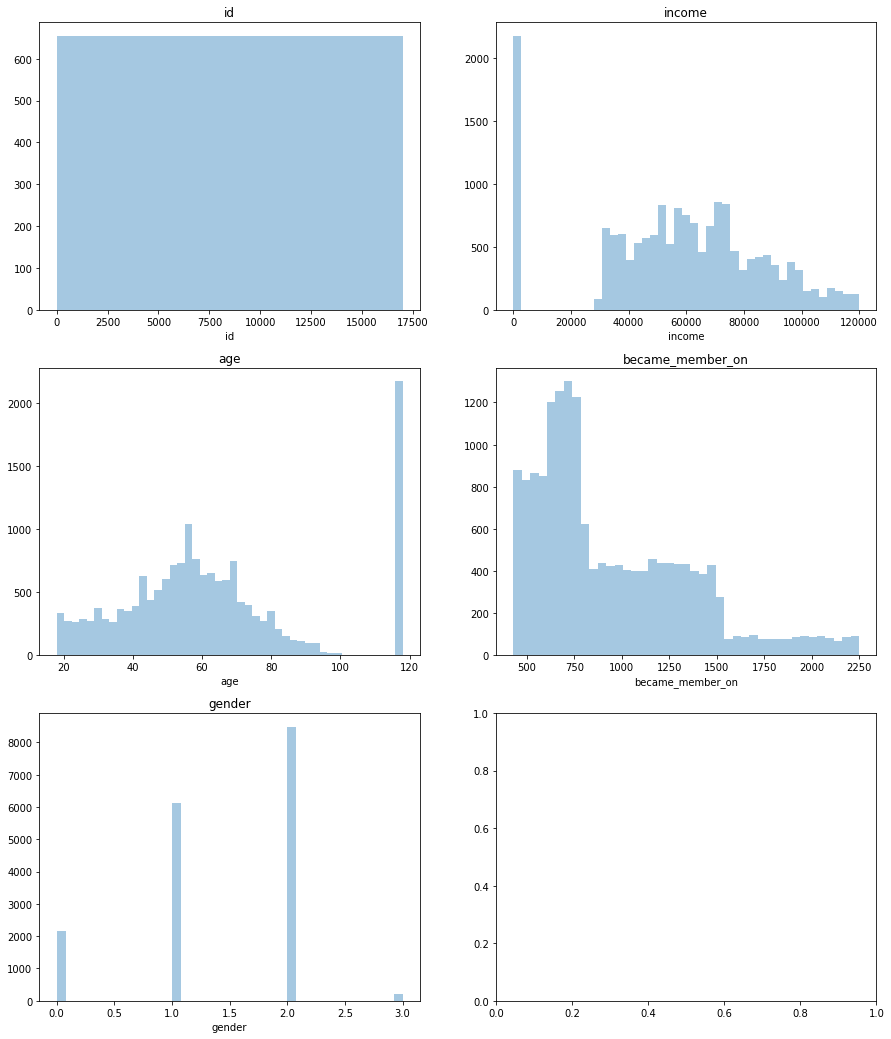

In [10]:
show_hist(profile)

In the graph above, the numbers of the missing values in `age` (118), `gender` (0), and `income` (0) are almost equal. So we should compare indexs of the raws which contain the missing values. If they are same indices, we can solve the problem by removing those raws. 

In [11]:
income_missing = profile[profile['income']==0].index
age_missing = profile[profile['age']==118].index
(income_missing!=age_missing).sum()

0

Because the missing values are located in same indices, we will remove those indice because those indices have no information about user.

In [12]:
people_remove = profile.loc[income_missing]['id']
profile=profile.drop(income_missing,axis=0)

I finished the cleaning processes for profile dataset. I will make these processes as a single function. And then, I will recall this function when I need. 

In [13]:
# make a function for all of processes for cleaning the profile dataset.
# After writing code, I copy this function to 'tools.py'

def profile_cleaning(df):
    '''
    This function is for cleaning the profile dataset
    --------
    Input:

    df: the profile dataset (the pandas dataframe)    
    --------
    Output:
    
    df: cleaned profile dataset
    peope_remove: a list(pandas Series) of people who have missing values. 
    user_dict: dict for changing user_id to simple int id
    
    '''      
    # move the 'id' column to the first of the dataset
    df = df[df.columns.tolist()[3:] + df.columns.tolist()[:3]] 
    
    # change id to int
    user_dict = id_mapper(df,'id')
    df['id']=df['id'].apply(lambda x: user_dict[x])
    
    # change genter to int
    gen_dict = dict()
    keys = df['gender'].unique().tolist()
    for i in range(len(keys)):
        gen_dict[keys[i]] = i
    df['gender'] = df['gender'].replace(gen_dict)
    
    # change became_member_on data to numbers of days from the signing date.
    today_ = pd.to_datetime('today')
    df['became_member_on'] = (today_- pd.to_datetime(df['became_member_on'],format='%Y%m%d')).astype('timedelta64[D]').astype(int)
    
    # remove rows with missing values
    missing_indice = df[df['age']==118].index
    people_remove = df.loc[missing_indice]['id']
    df=df.drop(missing_indice,axis=0)
    
    return df, people_remove, user_dict

In [2]:
from tools import id_mapper, profile_cleaning

profile_, people_remove, user_dict = profile_cleaning(profile)

In [3]:
profile_.head()

,id,income,age,became_member_on,gender
1,2,112000.0,55,805,1
3,4,100000.0,75,872,1
5,6,70000.0,68,520,2
8,9,53000.0,65,596,2
12,13,51000.0,58,686,2



## 1.2 'portfolio' dataset

This part is about `portfolio` dataset. We will map offer_ids to simple int values as we did above. And then, we will separate data in `channels` column to the one-hot encoded data for each channel.

**If you already finished making a function for cleaning profile, please skip this section and go to the last part of this section**

In [14]:
# Regarding this dataset,it has only 10 raws, so we don't use 'head' function
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [15]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [16]:
# change 'id' values to int data. we will use the id_mapper function which we made before.

offer_id_dict = id_mapper(portfolio,'id')
portfolio['id'] = portfolio['id'].apply(lambda x: offer_id_dict[x])

Below code is for change lists in `channaels` and `offer_type` comlumn to one-hot encoded data of each categories. We will use `apply` function in Pandas with lambda function. Then, we will drop the original column, and change the order of the columns.

In [17]:
def one_hot_encoding(df, target_column, categories):
    '''
    This is for changing categorical column to several columns of one_hot encoded.
    
    Input:
            df: Pandas DataFrame
            target_column: name of categorical column which we have to change
            categories: List of categories
            
    Output:
            df_new: Pandas DataFrame

    '''
    
    for i in categories:
        df[i] = df[target_column].apply(lambda x: 1 if i in x else 0)
    
    df = df.drop(target_column,axis=1)
    
    return df

In [18]:
portfolio = one_hot_encoding(portfolio,'offer_type',['bogo','informational','discount'])
portfolio = one_hot_encoding(portfolio,'channels',['email','mobile','web','social'])

In [19]:
portfolio['duration'] = portfolio['duration']*24

In [20]:
# change order of the columns
columns = portfolio.columns.tolist()
columns = columns[2::-1] + columns[3:]
portfolio = portfolio[columns]
portfolio

,id,duration,difficulty,reward,bogo,informational,discount,email,mobile,web,social
0,1,168,10,10,1,0,0,1,1,0,1
1,2,120,10,10,1,0,0,1,1,1,1
2,3,96,0,0,0,1,0,1,1,1,0
3,4,168,5,5,1,0,0,1,1,1,0
4,5,240,20,5,0,0,1,1,0,1,0
5,6,168,7,3,0,0,1,1,1,1,1
6,7,240,10,2,0,0,1,1,1,1,1
7,8,72,0,0,0,1,0,1,1,0,1
8,9,120,5,5,1,0,0,1,1,1,1
9,10,168,10,2,0,0,1,1,1,1,0


In [21]:
portfolio = portfolio.drop('email',axis=1)

As the last step of the cleaning process for portfolio, I will make a function which contain all of processes.

In [22]:
def portfolio_cleaning(df):
    
    '''
    This function is for cleaning the profile dataset
    --------
    Input:

    df: the profile dataset (the pandas dataframe)    
    --------
    Output:
    
    df: cleaned portfolio dataset
    offer_dict: dict for changing offer_id to simple int id
    
    '''  
    # change id to int
    offer_id_dict = id_mapper(df,'id')
    df['id'] = df['id'].apply(lambda x: offer_id_dict[x])
    
    # one hot encoding for categorical values
    df = one_hot_encoding(df,'offer_type',['bogo','informational','discount'])
    df = one_hot_encoding(df,'channels',['email','mobile','web','social'])
    
    # change value from days to hours
    df['duration'] = df['duration']*24
    
    # change column order
    columns = df.columns.tolist()
    columns = columns[2::-1] + columns[3:]
    df = df[columns]
    
    # drop the 'email' column because it is same for all of the rows
    df = df.drop('email',axis=1)
    
    return df, offer_id_dict

In [4]:
from tools import portfolio_cleaning, one_hot_encoding

portfolio_, offer_dict = portfolio_cleaning(portfolio)

In [5]:
portfolio_

,id,duration,difficulty,reward,bogo,informational,discount,mobile,web,social
0,1,168,10,10,1,0,0,1,0,1
1,2,120,10,10,1,0,0,1,1,1
2,3,96,0,0,0,1,0,1,1,0
3,4,168,5,5,1,0,0,1,1,0
4,5,240,20,5,0,0,1,0,1,0
5,6,168,7,3,0,0,1,1,1,1
6,7,240,10,2,0,0,1,1,1,1
7,8,72,0,0,0,1,0,1,0,1
8,9,120,5,5,1,0,0,1,1,1
9,10,168,10,2,0,0,1,1,1,0


## 1.3 'transcript' dataset

This part, we will handle `transcript` dataset. First, we will drop raws which has same user_id with which we dropped at profile section. Then, we will divide `transcript` dataset into `offer` dataset and `transaction` dataset based on value. 

**If you already finished making a function for cleaning profile, please skip this section and go to the last part of this section**

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
# mapping person's id with the dictionary which we made before
transcript['person']=transcript['person'].apply(lambda x: user_dict[x])

# this part is for removing raws for people who are identified as missing data
missing_idx = transcript[transcript['person'].isin(people_remove)].index
transcript=transcript.drop(missing_idx,axis=0)

In [26]:
# this part is for dividing the dataset in to 'offer' and 'transcation'

offer = transcript[transcript['event'] != 'transaction']
transaction = transcript[transcript['event'] == 'transaction']

Regarding `offer` dataset, we will extract 'offer_id' from `value` column and map them with the dictionary about offer_id which we made before. Also, we will make `reward` column with extracting data from `value` column. And then, we will merge `offer` dataset with `profile` and `portfolio` dataset. As a result of the process, each row will have all information about characteristic of offer and customer.

In [27]:
# extract 'offer_id' from 'value' column
offer['offer_id'] = offer['value'].apply(lambda x:list(x.values())[0])

# map 'offer_id' column with the dictionary which we made before
offer['offer_id'] = offer['offer_id'].apply(lambda x: offer_id_dict[x])

# drop the 'value' column
offer = offer.drop(['value'],axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
# merge the dataset with the 'profile' and 'portfolio' dataset
offer = offer.merge(profile, left_on='person', right_on='id')
offer = offer.merge(portfolio, left_on='offer_id', right_on = 'id')
offer = offer.drop(['id_x','id_y'],axis=1)

In [29]:
offer = offer.sort_values(by=['person','offer_id'])
offer.head(50)

,event,person,time,offer_id,income,age,became_member_on,gender,duration,difficulty,reward,bogo,informational,discount,mobile,web,social
84178,offer received,2,504,3,112000.0,55,804,1,96,0,0,0,1,0,1,1,0
14229,offer received,2,408,4,112000.0,55,804,1,168,5,5,1,0,0,1,1,0
14230,offer completed,2,528,4,112000.0,55,804,1,168,5,5,1,0,0,1,1,0
26888,offer received,4,408,1,100000.0,75,871,1,168,10,10,1,0,0,1,0,1
26889,offer viewed,4,408,1,100000.0,75,871,1,168,10,10,1,0,0,1,0,1
26890,offer completed,4,510,1,100000.0,75,871,1,168,10,10,1,0,0,1,0,1
0,offer received,4,0,4,100000.0,75,871,1,168,5,5,1,0,0,1,1,0
1,offer viewed,4,6,4,100000.0,75,871,1,168,5,5,1,0,0,1,1,0
2,offer completed,4,132,4,100000.0,75,871,1,168,5,5,1,0,0,1,1,0
14372,offer received,4,168,8,100000.0,75,871,1,72,0,0,0,1,0,1,0,1


In [30]:
# divide the 'offer dataset' by events
offer_received = offer[offer['event']=='offer received']
offer_viewed = offer[offer['event']=='offer viewed']
offer_completed = offer[offer['event']=='offer completed']

In [31]:
offer_received['viewed'] = 0
offer_received['completed'] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
def viewed_check(x,offer_viewed):
    '''
    This function is for judging the specific offer was viewed by specific customer. 
    It will return 1 if the customer viewed the offer. It will return 0 if the customer did not viewed the offer.
    --------
    Input:

    x: the offer_recieved dataset or the subset of offer_recieved (the pandas dataframe)  
    offer_viewed: 'offer_viewed' dataframe
    --------
    output:
    
    0: the customer did not viewed the offer.
    1: the customer viewed the offer.
    
    '''  
    # create person, offer, duration variables which belongs to a specific offer
    person = x['person']
    offer = x['offer_id']
    duration = x['duration']
    time = x['time']
    
    # make a list of time, when offers were viewed, from 'offer_viewed' dataset based on person and offer information
    viewed_list = offer_viewed.loc[(offer_viewed['person']==person) & (offer_viewed['offer_id']==offer)]['time'].tolist()
    for v in viewed_list:
        if ((v-time)<duration) & ((v-time)>=0):
            return 1
    return 0

In [34]:
offer_received['viewed'] = offer_received[['person','offer_id','time','duration']].apply(lambda x: viewed_check(x,offer_viewed),axis=1)   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
def completed_check(x,offer_completed):
    '''
    This function is for judging the specific offer was completed by specific customer. 
    It will return 1 if the customer completed the offer by duration. It will return 0 if the customer did not completed the offer.
    --------
    Input:

    x: the offer_recieved dataset or the subset of offer_recieved (the pandas dataframe) 
    offer_completed: 'offer_completed' dataframe
    --------
    output:
    
    0: the customer did not completed the offer.
    1: the customer completed the offer.
    
    '''  
    # create person, offer, duration variables which belongs to a specific offer
    person = x['person']
    offer = x['offer_id']
    duration = x['duration']
    time = x['time']
    
    # make a list of time, when offers were completed, from 'offer_completed' dataset based on person and offer information
    completed_list = offer_completed.loc[(offer_completed['person']==person) & (offer_completed['offer_id']==offer)]['time'].tolist()
    
    # judging the specific offer was completed by specific customer before duration was overed
    for c in completed_list:
        if ((c-time)<duration) & ((c-time)>=0):
            return 1
    return 0

In [36]:
def past_completed_count(x, offer):
    '''
    This function is for counting previous completed numbers
    
    Input:
        x: the offer_recieved dataset or the subset of offer_recieved (the pandas dataframe)     
        offer: 'offer_received' dataframe from 'completed_check' function
    ------
    Output:
        count: the number of offers which were completed in the past.
    '''
    
    time = x['time']
    person = x['person']
    offer_list = offer.loc[(offer['time']<time) & (offer['person']==person)]
    count = 0
    if len(offer_list)>0:
        count = offer_list['completed'].sum()
    return count

In [37]:
offer_received['completed'] = offer_received.apply(lambda x: completed_check(x,offer_completed),axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
offer_received['completed_count'] = offer.apply(lambda x: past_completed_count(x,offer_received), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
offer_received = offer_received.drop('event',axis=1)
offer_received.head(10)

,person,time,offer_id,income,age,became_member_on,gender,duration,difficulty,reward,bogo,informational,discount,mobile,web,social,viewed,completed,completed_count
84178,2,504,3,112000.0,55,804,1,96,0,0,0,1,0,1,1,0,0,0,1
14229,2,408,4,112000.0,55,804,1,168,5,5,1,0,0,1,1,0,0,1,0
26888,4,408,1,100000.0,75,871,1,168,10,10,1,0,0,1,0,1,1,1,1
0,4,0,4,100000.0,75,871,1,168,5,5,1,0,0,1,1,0,1,1,0
14372,4,168,8,100000.0,75,871,1,72,0,0,0,1,0,1,0,1,1,0,1
43129,4,504,9,100000.0,75,871,1,120,5,5,1,0,0,1,1,1,1,1,2
74120,6,336,3,70000.0,68,519,2,96,0,0,0,1,0,1,1,0,0,0,0
3,6,408,4,70000.0,68,519,2,168,5,5,1,0,0,1,1,0,1,1,0
84264,6,504,7,70000.0,68,519,2,240,10,2,0,0,1,1,1,1,1,1,1
60118,6,0,10,70000.0,68,519,2,168,10,2,0,0,1,1,1,0,1,0,0


Like handling `offer` dataset, we will extract values of the amounts of each transcation from `value` column.

In [40]:
# extract values of the amounts of each transcation from value column.
transaction['amount'] = transaction['value'].apply(lambda x:x['amount'])
transaction = transaction.drop('value',axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
# merge with the profile dataset to get personal information about customers 
transaction = transaction.merge(profile, left_on='person', right_on='id')

In [42]:
# drop the unnecessary part and duplicated part
transaction = transaction.drop(['event','id'],axis=1)

In [43]:
transaction.head()

,person,time,amount,income,age,became_member_on,gender
0,42,0,0.83,30000.0,20,1173,1
1,42,6,1.44,30000.0,20,1173,1
2,42,12,4.56,30000.0,20,1173,1
3,42,84,1.53,30000.0,20,1173,1
4,42,90,0.50,30000.0,20,1173,1


In [ ]:
def transcript_cleaning(df, profile, portfolio, user_dict, offer_id_dict, people_remove):
    
    '''
    This function is for cleaning the transcript dataset
    --------
    Input:

    df: the transcript dataset (the pandas dataframe) 
    profile: the cleaned profile dataset
    portfolio: the cleaned portfolio dataset
    user_dict: A dictionary with 'user id' as its keys and int values as its items
    offer_id_dict: A dictionary with with 'offer id' as its keys and int values as its items
    --------
    Output:
    
    df: cleaned portfolio dataset
    offer_dict: dict for changing offer_id to simple int id
    
    '''  
    
    # mapping person's id with the dictionary which we made before
    df['person']=df['person'].apply(lambda x: user_dict[x])

    # this part is for removing raws for people who are identified as missing data
    missing_idx = df[df['person'].isin(people_remove)].index
    df=df.drop(missing_idx,axis=0)
    offer = df[df['event'] != 'transaction']
    transaction = df[df['event'] == 'transaction']
    
    # this part is for cleaning offer part
    offer = offer_processing(offer,profile, portfolio,offer_id_dict)
    
    # this part is for cleaning transaction part
    transaction['amount'] = transaction['value'].apply(lambda x:x['amount'])
    transaction = transaction.drop('value',axis=1)
    transaction = transaction.merge(profile, left_on='person', right_on='id')
    return offer, transaction

In [ ]:
def offer_processing(df,profile, portfolio,offer_id_dict):
        
    '''
    This function is for pre-processing the 'offer' dataframe from the transcript dataset
    --------
    Input:

    df: the 'offer' dataframe from 'transcript' dataframe 
    profile: the cleaned profile dataset
    portfolio: the cleaned portfolio dataset
    offer_id_dict: A dictionary with with 'offer id' as its keys and int values as its items
    --------
    Output:
    
    offer_received: the processed 'offer' dataframe
    
    '''   
    
    # extract 'offer_id' from 'value' column
    df['offer_id'] = df['value'].apply(lambda x:list(x.values())[0])

    # map 'offer_id' column with the dictionary which we made before
    df['offer_id'] = df['offer_id'].apply(lambda x: offer_id_dict[x])

    # drop the 'value' column
    df = df.drop(['value'],axis=1)
    
    # merge the dataset with the 'profile' and 'portfolio' dataset
    df = df.merge(profile, left_on='person', right_on='id')
    df = df.merge(portfolio, left_on='offer_id', right_on = 'id')
    df = df.drop(['id_x','id_y'],axis=1)
    offer_received = df.loc[df['event']=='offer received']
    offer_viewed = df.loc[df['event']=='offer viewed']
    offer_completed = df.loc[df['event']=='offer completed']    
    offer_received['viewed'] = 0
    offer_received['completed'] = 0
    offer_received['viewed'] = offer_received[['person','offer_id','time','duration']].apply(lambda x: viewed_check(x,offer_viewed),axis=1)    
    offer_received['completed'] = offer_received.apply(lambda x: completed_check(x,offer_completed),axis=1)
    offer_received['completed_count'] = offer.apply(lambda x: past_completed_count(x,offer_received), axis=1)
    offer_received = offer_received.drop('event',axis=1)
    return offer_received

In [6]:
from tools import viewed_check, completed_check, past_completed_count, offer_processing, transcript_cleaning

offer, transaction = transcript_cleaning(transcript, profile_, portfolio_, user_dict, offer_dict, people_remove)

C:\Users\hsg82\Documents\Starbucks\tools.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['offer_id'] = df['value'].apply(lambda x:list(x.values())[0])
C:\Users\hsg82\Documents\Starbucks\tools.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['offer_id'] = df['offer_id'].apply(lambda x: offer_id_dict[x])
C:\Users\hsg82\Documents\Starbucks\tools.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [7]:
offer.head()

,person,time,offer_id,income,age,became_member_on,gender,duration,difficulty,reward,bogo,informational,discount,mobile,web,social,viewed,completed,completed_count
0,4,0,4,100000.0,75,872,1,168,5,5,1,0,0,1,1,0,1,1,0
3,6,408,4,70000.0,68,520,2,168,5,5,1,0,0,1,1,0,1,1,0
6,9,168,4,53000.0,65,596,2,168,5,5,1,0,0,1,1,0,1,0,1
8,9,408,4,53000.0,65,596,2,168,5,5,1,0,0,1,1,0,1,1,2
11,26,504,4,88000.0,56,518,1,168,5,5,1,0,0,1,1,0,1,0,4


In [8]:
transaction.head()

,event,person,time,amount,id,income,age,became_member_on,gender
0,transaction,42,0,0.83,42,30000.0,20,1174,1
1,transaction,42,6,1.44,42,30000.0,20,1174,1
2,transaction,42,12,4.56,42,30000.0,20,1174,1
3,transaction,42,84,1.53,42,30000.0,20,1174,1
4,transaction,42,90,0.50,42,30000.0,20,1174,1


# 2. Build a model

To build a model, we have to drop several columns in the 'offer' dataset. I decide to remove `person` and `offer_id` which mean ids of offer and customers (they are not the information about offers and customers). Also, I delete the `time` column because it just indicates the time of each activity. Finally, I drop `viewed` because we don't know whether the offer was viewed or not before the offer was provided.

In [11]:
# drop the unnecessary columns
offer_ = offer.drop(['person','offer_id','time','viewed'],axis=1)

To make a train, vaild, and test dataset, we will use `train_test_split` function in Scikit-learn. 

In [12]:
from sklearn.model_selection import train_test_split

# define input dataset X
X = offer_.drop('completed', axis = 1)


# save the column order (I will use this at '3.Make a recommendation system' part)
column_order = X.columns.tolist()

# defind label(target) y
y = offer_['completed']

# split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=30)

# split train and valid dataset
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=30)

To prevent **'Overfitting'**, we use 'PCA' method as 'dimentional reduction'. At this time, we use `PCA` function in Scikit-learn.

In [13]:
# reset index to prevent problems when we merge dataset with PCA dataset 
X_train = X_train.reset_index(drop=True)

In [14]:
from sklearn.decomposition import PCA

# pca with n_components=3
pca = PCA(n_components=3)
pca.fit(X_train)
X_pca = pd.DataFrame(pca.transform(X_train))

# merge pca dataframe with train dataset
X_train = pd.concat([X_train, X_pca], axis=1)
X_train.head()

,income,age,became_member_on,gender,duration,difficulty,reward,bogo,informational,discount,mobile,web,social,completed_count,0,1,2
0,50000.0,64,648,2,240,10,2,0,0,1,1,1,1,0,-15332.603221,-294.576745,-83.787324
1,52000.0,26,663,1,168,5,5,1,0,0,1,1,0,1,-13332.604859,-280.639944,-11.697116
2,53000.0,39,1476,3,168,10,2,0,0,1,1,1,0,4,-12332.195129,531.861703,-11.406417
3,73000.0,59,745,2,120,5,5,1,0,0,1,1,1,2,7667.441355,-209.182652,36.067848
4,37000.0,25,831,2,168,10,2,0,0,1,1,1,0,1,-28332.518746,-105.136227,-11.842041


Regarding machine learning model, I make a ensembled model with several models.<br/> ![Modeling Process](pic3.png)

In the training part, I will make 6 different models and 6 diffrent subsets of the training part using `Kfold` function in scikit-learn.
And then, to find the best ensemble model, I will try all of possible combinations with validation dataset.

In [15]:
# this part is for creating model variables

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from lightgbm import LGBMClassifier

classifiers = []
params = []

# create lgbm classifier and dict (params) for optimizing
lgbm_classifier = LGBMClassifier()
lgbm_params = {'num_leaves' : (70,80,90),
               'max_depth' : (7,8,9),
               'learning_rate': (0.1,0.15,0.2),
               'n_estimators' : (90,100,110,120)}
classifiers.append(lgbm_classifier)
params.append(lgbm_params)

# create xgb classifier and dict (params) for optimizing
xgb_classifier = XGBClassifier()
xgb_params = {'max_depth' : (3,4,5),
              'learning_rate': (0.1,0.15,0.2),
              'n_estimators' : (90,100,110,120)}
classifiers.append(xgb_classifier)
params.append(xgb_params)

# create catboost classifier
cat_classifier = CatBoostClassifier()
classifiers.append(cat_classifier)

# create gradientboosting classifier
grad_classifier = GradientBoostingClassifier()
classifiers.append(grad_classifier)

# create randomforest classifier
rand_classifier = RandomForestClassifier()
classifiers.append(rand_classifier)

# create bagging classifier based on decisiontreeclassifier
bag_classifier = BaggingClassifier(DecisionTreeClassifier(), n_estimators= 10, max_samples= 1.0)
classifiers.append(bag_classifier)

In [16]:
# this part is for training models. I will use Kfold function from scikit-learn.

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits = 6, shuffle=True, random_state=42)
n = 0
predicts = []
models = []

for train_index, test_index in kf.split(X_train):
    print(n)
    X_fold = X_train.iloc[train_index]
    y_fold = y_train.iloc[train_index]
    
    # optimzing first two models
    if n<2:
        rand_ = RandomizedSearchCV(classifiers[n],params[n],cv=5, n_iter=7, verbose=20) 
        rand_.fit(X_fold,y_fold)
        classifier_ = rand_.best_estimator_ 
    else:
        classifier_ = classifiers[n]
        classifier_.fit(X_fold,y_fold)
    pred_ = classifier_.predict(X_train)
    print(accuracy_score(y_train,pred_))
    
    # save predicts
    predicts.append(pred_)
    
    # save model
    models.append(classifier_)
    n= n+1

0
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15, score=0.7936348828467611, total=   0.6s
[CV] num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15, score=0.8050125313283208, total=   0.6s
[CV] num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15, score=0.7967418546365915, total=   0.6s
[CV] num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15, score=0.7911027568922305, total=   0.6s
[CV] num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=100, max_depth=7, learning_rate=0.15, score=0.7993482892593057, total=   0.6s
[CV] num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15, score=0.792507204610951, total=   0.7s
[CV] num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15 .


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15, score=0.8012531328320802, total=   0.7s
[CV] num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15 .


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15, score=0.7968671679197995, total=   0.8s
[CV] num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15 .


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.5s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15, score=0.7903508771929825, total=   0.7s
[CV] num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15 .


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=90, max_depth=9, learning_rate=0.15, score=0.7972176964531896, total=   0.7s
[CV] num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1 .


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s remaining:    0.0s


[CV]  num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1, score=0.7943866683373011, total=   0.7s
[CV] num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1 .


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   10.4s remaining:    0.0s


[CV]  num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1, score=0.8053884711779449, total=   0.7s
[CV] num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1 .


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.5s remaining:    0.0s


[CV]  num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1, score=0.7976190476190477, total=   0.7s
[CV] num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1 .


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   12.5s remaining:    0.0s


[CV]  num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1, score=0.7908521303258146, total=   0.7s
[CV] num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1 .


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   13.5s remaining:    0.0s


[CV]  num_leaves=90, n_estimators=120, max_depth=7, learning_rate=0.1, score=0.801980198019802, total=   0.7s
[CV] num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   14.5s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15, score=0.791379526375141, total=   0.7s
[CV] num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   15.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15, score=0.8037593984962406, total=   0.7s
[CV] num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   16.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15, score=0.7964912280701755, total=   0.7s
[CV] num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   17.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15, score=0.7904761904761904, total=   0.7s
[CV] num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15 


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   18.4s remaining:    0.0s


[CV]  num_leaves=80, n_estimators=120, max_depth=7, learning_rate=0.15, score=0.7965910515102144, total=   0.7s
[CV] num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1 .
[CV]  num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1, score=0.7945119659190578, total=   0.9s
[CV] num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1 .
[CV]  num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1, score=0.800125313283208, total=   0.9s
[CV] num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1 .
[CV]  num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1, score=0.7977443609022556, total=   1.0s
[CV] num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1 .
[CV]  num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1, score=0.7855889724310777, total=   1.0s
[CV] num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1 .
[CV]  num_leaves=70, n_estimators=120, max_depth=9, learning_rate=0.1, score=0.80248151397

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   34.9s finished


0.818546365914787
1
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] n_estimators=120, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=120, max_depth=4, learning_rate=0.15, score=0.7997744643528379, total=   5.1s
[CV] n_estimators=120, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  n_estimators=120, max_depth=4, learning_rate=0.15, score=0.7996491667710813, total=   5.1s
[CV] n_estimators=120, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV]  n_estimators=120, max_depth=4, learning_rate=0.15, score=0.7989974937343358, total=   5.1s
[CV] n_estimators=120, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.5s remaining:    0.0s


[CV]  n_estimators=120, max_depth=4, learning_rate=0.15, score=0.7932071688181477, total=   5.0s
[CV] n_estimators=120, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.9s remaining:    0.0s


[CV]  n_estimators=120, max_depth=4, learning_rate=0.15, score=0.798094999373355, total=   5.0s
[CV] n_estimators=100, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.3s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, learning_rate=0.15, score=0.800902142588648, total=   4.2s
[CV] n_estimators=100, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.9s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, learning_rate=0.15, score=0.800902142588648, total=   4.1s
[CV] n_estimators=100, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.4s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, learning_rate=0.15, score=0.7991228070175439, total=   4.0s
[CV] n_estimators=100, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.8s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, learning_rate=0.15, score=0.7928311818523625, total=   4.1s
[CV] n_estimators=100, max_depth=4, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   45.2s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, learning_rate=0.15, score=0.7985963153277353, total=   4.2s
[CV] n_estimators=100, max_depth=5, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   49.8s remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, learning_rate=0.15, score=0.7990226788622979, total=   5.2s
[CV] n_estimators=100, max_depth=5, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   55.5s remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, learning_rate=0.15, score=0.8031574990602681, total=   5.2s
[CV] n_estimators=100, max_depth=5, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.0min remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, learning_rate=0.15, score=0.8020050125313283, total=   5.2s
[CV] n_estimators=100, max_depth=5, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, learning_rate=0.15, score=0.7962150645444291, total=   5.2s
[CV] n_estimators=100, max_depth=5, learning_rate=0.15 ...............


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, learning_rate=0.15, score=0.7982203283619501, total=   5.2s
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.7988973812805413, total=   3.3s
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.8006515474251347, total=   3.3s
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.7996240601503759, total=   3.3s
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.5min remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.7945857876926933, total=   3.3s
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  1.5min remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.7968417094874044, total=   3.3s
[CV] n_estimators=100, max_depth=3, learning_rate=0.2 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.2, score=0.7997744643528379, total=   3.2s
[CV] n_estimators=100, max_depth=3, learning_rate=0.2 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.2, score=0.8021551184062148, total=   3.3s
[CV] n_estimators=100, max_depth=3, learning_rate=0.2 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.2, score=0.7993734335839598, total=   3.2s
[CV] n_estimators=100, max_depth=3, learning_rate=0.2 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.2, score=0.7920792079207921, total=   4.0s
[CV] n_estimators=100, max_depth=3, learning_rate=0.2 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.2, score=0.7955884196014538, total=   3.8s
[CV] n_estimators=120, max_depth=5, learning_rate=0.15 ..............

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  3.0min finished


0.810484544695071
2
Learning rate set to 0.047555
0:	learn: 0.6508087	total: 233ms	remaining: 3m 52s
1:	learn: 0.6150174	total: 343ms	remaining: 2m 51s
2:	learn: 0.5878273	total: 438ms	remaining: 2m 25s
3:	learn: 0.5639255	total: 549ms	remaining: 2m 16s
4:	learn: 0.5440839	total: 662ms	remaining: 2m 11s
5:	learn: 0.5293205	total: 760ms	remaining: 2m 5s
6:	learn: 0.5174130	total: 862ms	remaining: 2m 2s
7:	learn: 0.5057904	total: 969ms	remaining: 2m
8:	learn: 0.4963196	total: 1.09s	remaining: 2m
9:	learn: 0.4889957	total: 1.19s	remaining: 1m 58s
10:	learn: 0.4820162	total: 1.31s	remaining: 1m 57s
11:	learn: 0.4758962	total: 1.43s	remaining: 1m 57s
12:	learn: 0.4712281	total: 1.52s	remaining: 1m 55s
13:	learn: 0.4670472	total: 1.63s	remaining: 1m 54s
14:	learn: 0.4627535	total: 1.73s	remaining: 1m 53s
15:	learn: 0.4590700	total: 1.82s	remaining: 1m 52s
16:	learn: 0.4555073	total: 1.95s	remaining: 1m 53s
17:	learn: 0.4525044	total: 2.05s	remaining: 1m 51s
18:	learn: 0.4497964	total: 2.15s	

158:	learn: 0.4047992	total: 16.6s	remaining: 1m 27s
159:	learn: 0.4047847	total: 16.7s	remaining: 1m 27s
160:	learn: 0.4047347	total: 16.8s	remaining: 1m 27s
161:	learn: 0.4047104	total: 16.9s	remaining: 1m 27s
162:	learn: 0.4046456	total: 17s	remaining: 1m 27s
163:	learn: 0.4046011	total: 17.1s	remaining: 1m 26s
164:	learn: 0.4045358	total: 17.2s	remaining: 1m 26s
165:	learn: 0.4044769	total: 17.3s	remaining: 1m 26s
166:	learn: 0.4044519	total: 17.4s	remaining: 1m 26s
167:	learn: 0.4044129	total: 17.5s	remaining: 1m 26s
168:	learn: 0.4043834	total: 17.6s	remaining: 1m 26s
169:	learn: 0.4043667	total: 17.7s	remaining: 1m 26s
170:	learn: 0.4043115	total: 17.8s	remaining: 1m 26s
171:	learn: 0.4042757	total: 17.9s	remaining: 1m 26s
172:	learn: 0.4042112	total: 18s	remaining: 1m 25s
173:	learn: 0.4041849	total: 18.1s	remaining: 1m 25s
174:	learn: 0.4041597	total: 18.2s	remaining: 1m 25s
175:	learn: 0.4041510	total: 18.2s	remaining: 1m 25s
176:	learn: 0.4041453	total: 18.3s	remaining: 1m 2

314:	learn: 0.4017385	total: 31s	remaining: 1m 7s
315:	learn: 0.4017032	total: 31.1s	remaining: 1m 7s
316:	learn: 0.4016398	total: 31.3s	remaining: 1m 7s
317:	learn: 0.4016224	total: 31.3s	remaining: 1m 7s
318:	learn: 0.4015798	total: 31.4s	remaining: 1m 7s
319:	learn: 0.4015688	total: 31.5s	remaining: 1m 6s
320:	learn: 0.4015686	total: 31.6s	remaining: 1m 6s
321:	learn: 0.4015683	total: 31.7s	remaining: 1m 6s
322:	learn: 0.4015668	total: 31.8s	remaining: 1m 6s
323:	learn: 0.4015512	total: 31.9s	remaining: 1m 6s
324:	learn: 0.4015369	total: 32s	remaining: 1m 6s
325:	learn: 0.4015208	total: 32.1s	remaining: 1m 6s
326:	learn: 0.4015200	total: 32.2s	remaining: 1m 6s
327:	learn: 0.4014963	total: 32.3s	remaining: 1m 6s
328:	learn: 0.4014788	total: 32.4s	remaining: 1m 6s
329:	learn: 0.4014769	total: 32.5s	remaining: 1m 5s
330:	learn: 0.4014735	total: 32.5s	remaining: 1m 5s
331:	learn: 0.4014688	total: 32.6s	remaining: 1m 5s
332:	learn: 0.4014526	total: 32.8s	remaining: 1m 5s
333:	learn: 0.40

475:	learn: 0.3996524	total: 45.9s	remaining: 50.5s
476:	learn: 0.3996524	total: 46s	remaining: 50.4s
477:	learn: 0.3996519	total: 46s	remaining: 50.3s
478:	learn: 0.3996271	total: 46.2s	remaining: 50.2s
479:	learn: 0.3995922	total: 46.3s	remaining: 50.1s
480:	learn: 0.3995688	total: 46.4s	remaining: 50s
481:	learn: 0.3995662	total: 46.5s	remaining: 49.9s
482:	learn: 0.3995412	total: 46.6s	remaining: 49.8s
483:	learn: 0.3995409	total: 46.6s	remaining: 49.7s
484:	learn: 0.3995263	total: 46.7s	remaining: 49.6s
485:	learn: 0.3995260	total: 46.8s	remaining: 49.5s
486:	learn: 0.3995055	total: 46.9s	remaining: 49.4s
487:	learn: 0.3994935	total: 47s	remaining: 49.3s
488:	learn: 0.3994921	total: 47.1s	remaining: 49.2s
489:	learn: 0.3994644	total: 47.2s	remaining: 49.1s
490:	learn: 0.3994635	total: 47.3s	remaining: 49s
491:	learn: 0.3994603	total: 47.3s	remaining: 48.9s
492:	learn: 0.3994595	total: 47.4s	remaining: 48.8s
493:	learn: 0.3994443	total: 47.5s	remaining: 48.7s
494:	learn: 0.3994426	

635:	learn: 0.3982048	total: 1m	remaining: 34.6s
636:	learn: 0.3982047	total: 1m	remaining: 34.5s
637:	learn: 0.3982045	total: 1m	remaining: 34.4s
638:	learn: 0.3982034	total: 1m	remaining: 34.3s
639:	learn: 0.3982032	total: 1m	remaining: 34.2s
640:	learn: 0.3981965	total: 1m	remaining: 34.1s
641:	learn: 0.3981960	total: 1m	remaining: 34s
642:	learn: 0.3981854	total: 1m 1s	remaining: 33.9s
643:	learn: 0.3981851	total: 1m 1s	remaining: 33.8s
644:	learn: 0.3981846	total: 1m 1s	remaining: 33.7s
645:	learn: 0.3981811	total: 1m 1s	remaining: 33.6s
646:	learn: 0.3981806	total: 1m 1s	remaining: 33.5s
647:	learn: 0.3981805	total: 1m 1s	remaining: 33.4s
648:	learn: 0.3981804	total: 1m 1s	remaining: 33.3s
649:	learn: 0.3981802	total: 1m 1s	remaining: 33.2s
650:	learn: 0.3981771	total: 1m 1s	remaining: 33.1s
651:	learn: 0.3981765	total: 1m 1s	remaining: 33s
652:	learn: 0.3981763	total: 1m 1s	remaining: 32.8s
653:	learn: 0.3981614	total: 1m 1s	remaining: 32.8s
654:	learn: 0.3981339	total: 1m 2s	re

794:	learn: 0.3970569	total: 1m 14s	remaining: 19.2s
795:	learn: 0.3970567	total: 1m 14s	remaining: 19.1s
796:	learn: 0.3970551	total: 1m 14s	remaining: 19s
797:	learn: 0.3970460	total: 1m 14s	remaining: 18.9s
798:	learn: 0.3970234	total: 1m 14s	remaining: 18.8s
799:	learn: 0.3970134	total: 1m 14s	remaining: 18.7s
800:	learn: 0.3970131	total: 1m 14s	remaining: 18.6s
801:	learn: 0.3970092	total: 1m 14s	remaining: 18.5s
802:	learn: 0.3970080	total: 1m 15s	remaining: 18.4s
803:	learn: 0.3969601	total: 1m 15s	remaining: 18.3s
804:	learn: 0.3969533	total: 1m 15s	remaining: 18.2s
805:	learn: 0.3969517	total: 1m 15s	remaining: 18.1s
806:	learn: 0.3969429	total: 1m 15s	remaining: 18.1s
807:	learn: 0.3969313	total: 1m 15s	remaining: 18s
808:	learn: 0.3969198	total: 1m 15s	remaining: 17.9s
809:	learn: 0.3968720	total: 1m 15s	remaining: 17.8s
810:	learn: 0.3968715	total: 1m 15s	remaining: 17.7s
811:	learn: 0.3968442	total: 1m 15s	remaining: 17.6s
812:	learn: 0.3968441	total: 1m 16s	remaining: 17.

951:	learn: 0.3957245	total: 1m 28s	remaining: 4.45s
952:	learn: 0.3957232	total: 1m 28s	remaining: 4.36s
953:	learn: 0.3957119	total: 1m 28s	remaining: 4.26s
954:	learn: 0.3956921	total: 1m 28s	remaining: 4.17s
955:	learn: 0.3956639	total: 1m 28s	remaining: 4.08s
956:	learn: 0.3956506	total: 1m 28s	remaining: 3.99s
957:	learn: 0.3956094	total: 1m 28s	remaining: 3.9s
958:	learn: 0.3955997	total: 1m 28s	remaining: 3.8s
959:	learn: 0.3955970	total: 1m 29s	remaining: 3.71s
960:	learn: 0.3955755	total: 1m 29s	remaining: 3.62s
961:	learn: 0.3955685	total: 1m 29s	remaining: 3.52s
962:	learn: 0.3955395	total: 1m 29s	remaining: 3.43s
963:	learn: 0.3955366	total: 1m 29s	remaining: 3.34s
964:	learn: 0.3955334	total: 1m 29s	remaining: 3.25s
965:	learn: 0.3955086	total: 1m 29s	remaining: 3.15s
966:	learn: 0.3955083	total: 1m 29s	remaining: 3.06s
967:	learn: 0.3955082	total: 1m 29s	remaining: 2.97s
968:	learn: 0.3955060	total: 1m 29s	remaining: 2.87s
969:	learn: 0.3955036	total: 1m 29s	remaining: 2

C:\Anaconda3\envs\data_basic\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9456766917293233
5
0.946031746031746


In [17]:
# let's check accuracy score of a model which is consisted with 6 models
predicts_ = pd.DataFrame(predicts).transpose()
predicts_['avg'] = predicts_.mean(axis=1).round()
accuracy_score(y_train,predicts_['avg'])

0.8270885547201337

In [18]:
# apply pca for validation dataset
X_val = X_val.reset_index(drop=True)
X_val_pca = pca.transform(X_val)
X_val_pca = pd.DataFrame(X_val_pca)
X_val = pd.concat([X_val,X_val_pca], axis=1)

In [20]:
# list for saving predicted value
predicts_val = []

for i in range(len(models)):
    pred_ = models[i].predict(X_val)
    predicts_val.append(pred_)
predicts_val = pd.DataFrame(predicts_val).transpose()
y_pred = predicts_val.mean(axis=1).round()
accuracy_score(y_val,y_pred)

0.8030075187969925

In [22]:
# find the best combination of the models
from itertools import combinations 

privious_score = 0
best_comb = []
for i in range(1,6):
    comb_list = combinations([0,1,2,3,4], i)
    for comb in comb_list:
        comb = list(comb)
        pred_ = predicts_val[comb].mean(axis=1).round()
        score = accuracy_score(y_val,pred_)
        print(score)
        if score>privious_score:
            privious_score = score
            best_comb = comb
print("best_score is : {}".format(privious_score))
print("best_combination is : {}".format(best_comb))

0.8048872180451128
0.8039473684210526
0.8013157894736842
0.8028195488721804
0.7712406015037594
0.8024436090225564
0.8013157894736842
0.8016917293233082
0.7772556390977443
0.8018796992481203
0.8011278195488721
0.7785714285714286
0.8015037593984963
0.7770676691729324
0.7755639097744361
0.8033834586466165
0.806015037593985
0.8037593984962406
0.8026315789473685
0.8041353383458647
0.8048872180451128
0.8041353383458647
0.8033834586466165
0.8045112781954887
0.8011278195488721
0.8030075187969925
0.8022556390977443
0.8026315789473685
0.8018796992481203
0.8018796992481203
0.8052631578947368
best_score is : 0.806015037593985
best_combination is : [0, 1, 3]


In [23]:
# apply pca for test dataset
X_test = X_test.reset_index(drop=True)
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca)
X_test = pd.concat([X_test,X_test_pca], axis=1)

In [24]:
predicts_test = []

for i in range(len(models)):
    pred_ = models[i].predict(X_test)
    predicts_test.append(pred_)
predicts_test = pd.DataFrame(predicts_test).transpose()
y_pred = predicts_test[best_comb].mean(axis=1).round()

accuracy_score(y_test,y_pred)

0.8030975114653034

# Make a 'offer' recommendation system

This recommendation system is mainly depend on the ML model which I made above. With information about customer, the system calculates probabilities for completion of each offers. Also, I calculated completion rates of each offer, and it will be used to sorting offers which has same probability. 

In [25]:
# calculate completion rates of each offer on the portfolio
offer_popularity = offer[['offer_id','completed']].groupby('offer_id').mean()\
                                                                      .rename(columns={'completed':'completion_rate'})\
                                                                      .sort_values(by='completion_rate')


In [39]:
def recommendating_offer(person,models,best_comb):
    '''
    This function is for creating a pandas DataFrame which is sorted by probabilities and completion rate of each offers 
    -----
    Input:
        person: a pandas dataframe which contains personal information of a customer
        models: a list of trained machine learning models
        best_comb: a list of the best combination
    
    -----
    Output:
        recommendations: a pandas DataFrame which cotain completion probabilities ('model_estimate' column)
        and completion rate('completion_rate' column) of each offer.
    
    '''
    # create dictionaries for saving completion probabilities
    scores = {x:0 for x in portfolio['id'].tolist()}
    
    # drop unnecessary column
    offer_list = portfolio_.drop('id',axis=1)
    
    # run the loop statement for each offer to get the probabilities
    for i in range(1, offer_list.shape[1]+1):
        target_offer = offer_list.iloc[i]
        target_ = pd.DataFrame(pd.concat([person,target_offer], axis=0)).transpose()
        target_ = target_[column_order]
        target_pca = pd.DataFrame(pca.transform(target_))
        target_ = pd.concat([target_,target_pca], axis=1)
        predicts_ = []
        for j in best_comb:
            pred_ = models[j].predict(target_)
            predicts_.append(pred_)
        scores[i] = pd.DataFrame(predicts_).mean()[0]
    recommendations = pd.DataFrame(offer_popularity)
    recommendations['model_estimates'] = recommendations.index.to_series().map(scores)
    recommendations = recommendations[['model_estimates','completion_rate']].sort_values(by=['model_estimates','completion_rate'], ascending=False)

    return recommendations

In [38]:
person_x = profile_.iloc[4875]
person_x['completed_count'] = 1
person_x = person_x.drop('id')
rec_ = recommendating_offer(person_x, models, best_comb)
rec_

C:\Anaconda3\envs\data_basic\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\envs\data_basic\lib\site-packages\pandas\core\series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


,model_estimates,completion_rate
offer_id,,
6,1.000000,0.728024
9,1.000000,0.611466
5,1.000000,0.500595
3,0.666667,0.000000
4,0.333333,0.619147
8,0.333333,0.000000
7,0.000000,0.751052
10,0.000000,0.582114
1,0.000000,0.540775


For example, the ML model estimated probabilities of each offer as 'model_estimates' column. Also, I put the completion_rate of each column from the `offer` dataset which I made at 'cleaning dataset' part. 